In [9]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%qtconsole
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import bresenham
from skimage.morphology import dilation, square
import scipy
import scipy.io

In [3]:
def read_file(filename, delimiter=' ', skip=()):
    points = {'x' : [], 'y': [], 'p': []}
    if(filename.endswith('.HWR')):
        with open(filename) as csvfile:
            reader = csv.reader(csvfile, delimiter=delimiter)

            # ignore two first lines
            # reader.next()
            # reader.next()
            for r in reader:
                row = [ x for x in r if x.isdigit() ]
                points['x'].append(row[0])
                points['y'].append(row[1])
                points['p'].append(row[2])

    elif (filename.endswith('.mat')):

        mat = scipy.io.loadmat(filename)
        points['x'] = mat['x'].flatten()
        points['y'] = mat['y'].flatten()
        points['p'] = mat['p'].flatten()


    return points

In [4]:
points = read_file('dataset/u1001s0001_sg0001.mat')
rtab = 2540.0
# rscan = 400.0 # for Sigcomp
rscan = 600.0 # for Biosecurid

# frequency_rate = 200.0 # 200 Hz for sigcomp

frequency_rate = 100.0 # 100 Hz for biosecurid

factor = rscan / rtab

xs = np.array(points['x']).astype('int') * factor
ys = np.array(points['y']).astype('int') * factor
p  = np.array(points['p']).astype('int')
size = len(xs)

period = 1 / frequency_rate
total_time = size * period

time = np.arange(0, total_time, period)

speed = []

for i in range(size-1):
    x_i = xs[i]
    y_i = ys[i]
    x_i1 = xs[i+1]
    y_i1 = ys[i+1]

    t_i = time[i]
    t_i1 = time[i+1]

    sx = x_i1 - x_i
    sy = y_i1 - y_i

    st = (t_i1 - t_i)
    vx = sx / st
    vy = sy / st

    speed.append((vx, vy))
    
speed.append(speed[size-2])

h = int(xs.max()) + 1
w = int(ys.max()) + 1


img_s = np.zeros((w, h))
img_spu = np.zeros((w, h))

In [5]:
for i in range(size):
        x = int(xs[i])
        y = int(ys[i])

        pixels = [(x, y)]

        if i < size-1:
            next_x = int(xs[i+1])
            next_y = int(ys[i+1])
            more_pixels = bresenham.get_line((x, y), (next_x, next_y))
            for pixel in more_pixels:
                pixels.append(pixel)

        for pixel in pixels:
            (xp, yp) = pixel

            if p[i] == 0:
                img_spu[yp, xp] = 1

            elif p[i] > 0:
                img_s[yp, xp] = 1

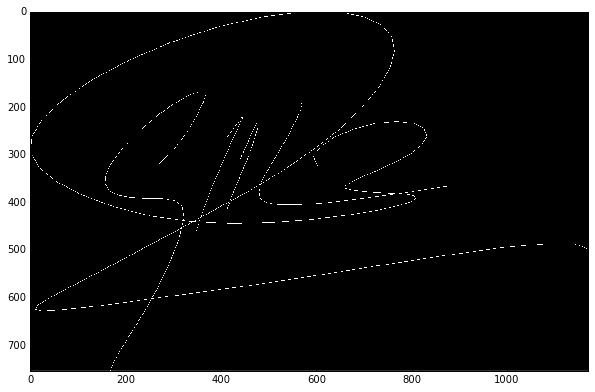

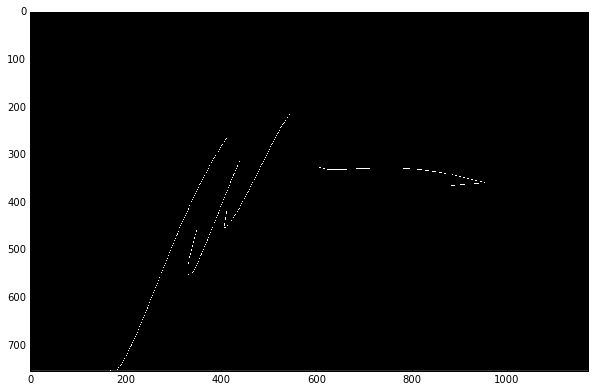

In [6]:
non_empty = np.where(img_s > 0)
cropBox = (min(non_empty[0]), max(non_empty[0]), min(non_empty[1]), max(non_empty[1]))
img_new_s = img_s[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]
img_new_spu = img_spu[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]
img_new_s = np.flipud(img_new_s)
img_new_spu = np.flipud(img_new_spu)


scipy.misc.imsave('is.png', img_new_s)
scipy.misc.imsave('ispu.png', img_new_spu)

plt.imshow(img_new_s)
plt.figure()
plt.imshow(img_new_spu)
plt.show()
